In [1]:
import glob
from PIL import Image
import numpy as np

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg16

In [3]:
color_2_index = np.asarray([
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
    ])

class_names = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
                'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
                'dog', 'horse', 'motorbike', 'person', 'potted-plant',
                'sheep', 'sofa', 'train', 'tv/monitor']

In [4]:
path = "data/VOCdevkit/VOC2012/"
img_size = 224
device = "cuda"
seed = 42

In [5]:
class PascalVoc(Dataset):
    def __init__(self, path, img_size):
        self.seg_folder = "SegmentationClass/"
        self.img_folder = "JPEGImages/"
        self.path = path

        self.segmentation_imgs = glob.glob(path + self.seg_folder + "*")
        self.img_size = img_size

        self.mean = torch.tensor([0.485, 0.456, 0.406]).view((1, 1, 3))
        self.std = torch.tensor([0.229, 0.224, 0.225]).view((1, 1, 3))
    
    def load_imgs(self, idx):
        mask_path = self.segmentation_imgs[idx]
        file_name = mask_path.split("\\")[1]

        mask_img = Image.open(mask_path).convert('RGB')
        mask_img = mask_img.resize((self.img_size, self.img_size))
        
        img_name = self.path + self.img_folder + file_name
        img_name = img_name.split(".")[0] + ".jpg"

        img = Image.open(img_name)
        img = img.resize((self.img_size, self.img_size))
        
        return (mask_img, img)
    
    @staticmethod
    def create_label_mask(mask_img):
        mask = np.array(mask_img).astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)

        for idx, label in enumerate(color_2_index):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = idx

        label_mask = label_mask.astype(int)
        return label_mask
    
    def __getitem__(self, idx):
        mask_img, img = self.load_imgs(idx)
        
        mask_img = PascalVoc.create_label_mask(mask_img)
        mask_img = torch.from_numpy(mask_img).long()
        
        img = torch.from_numpy(np.array(img)).float() / 255
        img = (img - self.mean) / self.std

        img = img.permute((2, 0, 1)).contiguous()

        img = img.to(device)
        mask_img = mask_img.to(device)

        return (img, mask_img)

    def __len__(self):
        return len(self.segmentation_imgs)
    
    def get_img_masks(self, idx):
        """
        Function to return true image (un-modified), img and mask_img.
        Used for validating results (visually).
        """

        img, _ = self.__getitem__(idx)
        mask_img, pil_img = self.load_imgs(idx)
        
        return (pil_img, img, mask_img)

In [6]:
batch_size = 32
dataset = PascalVoc(path, img_size)
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=0)

In [7]:
class trans_conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels,
                                       kernel_size=3, stride=stride,
                                       padding=1, output_padding=1)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        return x

class fcn_8(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.num_classes = num_classes

        # Indicies used for FCN-8
        self.fcn_block_indicies = [(0, 17), (17, 24), (24, 31)]
        self.init_vgg()

        self.pool_5_upsample = trans_conv2d(512, 512)
        self.pool_4_upsample = trans_conv2d(512, 256) 
        self.pool_3_upsample = trans_conv2d(256, 128)

        self.upsample_score_1 = trans_conv2d(128, 64)
        self.upsample_score_2 = trans_conv2d(64, 32)

        self.out_conv = nn.Conv2d(32, self.num_classes, kernel_size=1)

    def init_vgg(self):
        model = vgg16(pretrained=True)
        del model.classifier
        model = model.to(device)
        
        self.blocks = []
        
        for block_idx in self.fcn_block_indicies:
            self.blocks.append(model.features[block_idx[0]:block_idx[1]])
        
        # The network does not update the VGG weights
        for block in self.blocks:
            for param in block.parameters():
                param.requires_grad = False        
    
    def forward(self, x):
        x_3 = self.blocks[0](x)
        x_4 = self.blocks[1](x_3)
        x_5 = self.blocks[2](x_4)
        
        x_5 = self.pool_5_upsample(x_5)
        x_4 = self.pool_4_upsample(x_4 + x_5)
        x_3 = self.pool_3_upsample(x_3 + x_4)
        
        score = self.upsample_score_1(x_3)
        score = self.upsample_score_2(score)
        
        score = self.out_conv(score)
        score = F.log_softmax(score, dim=1)
        return score

In [8]:
torch.manual_seed(seed)
model = fcn_8(len(class_names)).to(device)

In [9]:
num_epochs = 20

lr = 2e-3
wd = 1e-5
lr_decay = 0.5

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
loss_fct = nn.NLLLoss()

In [10]:
torch.manual_seed(seed)
model.train()
for epoch in range(1, num_epochs+1):
    loss = 0.0
    acc = 0.0
    for _, (x, y) in enumerate(dataloader):
        optimizer.zero_grad()
        
        y_hat = model(x)
        batch_loss = loss_fct(y_hat, y)
        batch_loss = batch_loss / x.shape[0]
        batch_loss.backward()
        optimizer.step()
        
        batch_loss = batch_loss.detach().cpu().numpy()
        loss += batch_loss
        
        preds = torch.argmax(y_hat, dim=1)
        batch_acc = torch.sum(preds == y).float() / (img_size * img_size)
        batch_acc = batch_acc.detach().cpu().numpy()
        
        acc += batch_acc / x.shape[0]
        #print(batch_loss)
    
    loss = loss / len(dataloader)
    acc = acc / len(dataloader)
    
    print(f"-------Epoch {epoch}-------")
    print(f"Loss : {loss}")
    print(f"Accuracy: {acc}")
    
    if epoch % 5 == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * lr_decay
            
        print(f"Decreasing the learning rate to {param_group['lr']}")

-------Epoch 1-------
Loss : 0.06661285188696954
Accuracy: 0.732908936176935
-------Epoch 2-------
Loss : 0.06379864860892943
Accuracy: 0.7456383721336074
-------Epoch 3-------
Loss : 0.06328133532129553
Accuracy: 0.7410978827139606
-------Epoch 4-------
Loss : 0.05897370588196361
Accuracy: 0.7522660137518592
-------Epoch 5-------
Loss : 0.051889551358054516
Accuracy: 0.7533213437899299
Decreasing the learning rate to 0.001
-------Epoch 6-------
Loss : 0.04337567809726233
Accuracy: 0.7535410063422244
-------Epoch 7-------
Loss : 0.036298254099876984
Accuracy: 0.7552203736875368
-------Epoch 8-------
Loss : 0.03493426845449468
Accuracy: 0.7634251461080883
-------Epoch 9-------
Loss : 0.03014899729548589
Accuracy: 0.7704780451629473
-------Epoch 10-------
Loss : 0.027400070193993008
Accuracy: 0.7757295130387597
Decreasing the learning rate to 0.0005
-------Epoch 11-------
Loss : 0.0254317508281573
Accuracy: 0.7825016379356384
-------Epoch 12-------
Loss : 0.024434678155280973
Accuracy: 0

In [11]:
model.eval()

idx = 0
(img, x, y) = dataset.get_img_masks(idx)
x = x.reshape((1, 3, img_size, img_size))

y_hat = model(x)
y_hat = torch.argmax(y_hat, dim=1)[0, :, :]
y_hat = y_hat.detach().cpu().numpy()

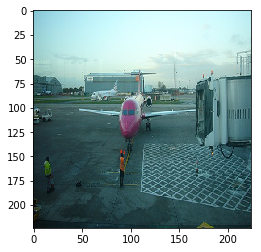

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

img = np.array(img)
plt.imshow(img)
plt.show()

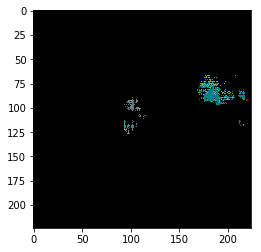

In [13]:
y_hat_mask = np.zeros((img_size, img_size, 3))

for i in range(img_size):
    for j in range(img_size):
        y_hat_mask[i, j, :] = color_2_index[y_hat[i, j]]
        
y_hat_mask = y_hat_mask.astype(int)

plt.imshow(y_hat_mask)
plt.show()

In [14]:
set(y_hat.reshape(img_size*img_size))

{0, 5, 6, 7, 14, 15, 19}

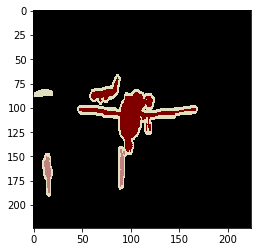

In [15]:
plt.imshow(y)
plt.show()